In [1]:
import sys
import glob,os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append("../")
import utils.data_utils as du
import utils.visualization_utils as vu

Goal: parameters to skim light-curves
1. time: get a light-curve with time span similar to training sample
2. S/N: maglims are not computed here, although we trained with them, maybe real data has larger S/N than sims
3. multiseason transients: although BRNNs should deal with this, eliminating crappy lcs should be good for overall efficiency.

In [2]:
# Init paths
path_raw = os.environ.get("DES_DATA")
path_dump = './dump/data_skimming/'

In [3]:
# config
# debug 
debug = False

In [4]:
# load data
# do run: process_Data_for_notebooks.py first! the notebook crashes with such large data to process
df_real = du.load_data(f"{path_raw}DESALL_forcePhoto_real_snana_fits/","./dump/real/",redo_photometry = False)
df_fake = du.load_data(f"{path_raw}/DESALL_forcePhoto_fake_snana_fits/","./dump/fake/",redo_photometry = False)

[Loading preprocessed data ./dump/real/DESY4_forcePhoto_real_snana_fits_PHOT.pickle] 
[Loading preprocessed data ./dump/real/DESY2_forcePhoto_real_snana_fits_PHOT.pickle] 
[Loading preprocessed data ./dump/real/DESY1_forcePhoto_real_snana_fits_PHOT.pickle] 
[Loading preprocessed data ./dump/real/DESY3_forcePhoto_real_snana_fits_PHOT.pickle] 
[Loading preprocessed data ./dump/real/DESY5_forcePhoto_real_snana_fits_PHOT.pickle] 


../utils/data_utils.py:47: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df_tmp[i] for i in range(len(df_tmp))])


[Loading preprocessed data ./dump/fake/DESY3_forcePhoto_fake_snana_fits_PHOT.pickle] 
[Loading preprocessed data ./dump/fake/DESY5_forcePhoto_fake_snana_fits_PHOT.pickle] 
[Loading preprocessed data ./dump/fake/DESY4_forcePhoto_fake_snana_fits_PHOT.pickle] 
[Loading preprocessed data ./dump/fake/DESY2_forcePhoto_fake_snana_fits_PHOT.pickle] 
[Loading preprocessed data ./dump/fake/DESY1_forcePhoto_fake_snana_fits_PHOT.pickle] 


In [5]:
# BEWARE! SNID for fakes is actually NOT the real SNID
df_fake['SNID']= df_fake['PRIVATE(DES_snid)']

# Data exploration

0.0     17955163
16.0     2422853
4.0      2047097
8.0      2031903
Name: PRIVATE(DES_transient_status), dtype: int64


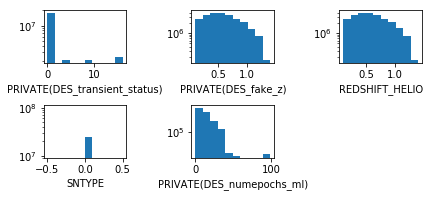

In [6]:
# Variable inspection
# general dist
list_var = ['PRIVATE(DES_transient_status)','PRIVATE(DES_fake_z)','REDSHIFT_HELIO','SNTYPE','PRIVATE(DES_numepochs_ml)']
fig = plt.figure()
for i,var in enumerate(list_var):
    ax=plt.subplot(3,3,i+1)
    ax.hist(df_fake[var])
    ax.set_yscale("log")
    ax.set_xlabel(var)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
# all Ias and no transient status
# print(df_fake['PRIVATE(DES_transient_status)'].unique(),df_fake['SNTYPE'].unique())
print(df_fake['PRIVATE(DES_transient_status)'].value_counts())
# print(df_fake['PRIVATE(DES_numepochs_ml)'].value_counts())

So basically this means that transient_status:
- (False) if it was properly run on fakes then it is not a good indicator of the good light-curves
- (True) if it wasnt properly run, either rerun it or not use it in fakes, only in data 
- I could see if I construct my own transient status with numepochs. To be done next week (~April 20th) with Mat Smith

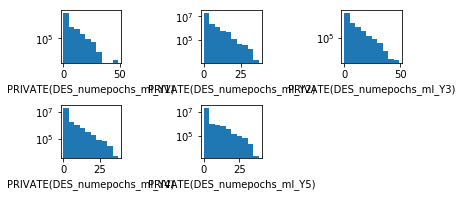

In [7]:
# ML Real Bogus
list_var_ML = ['PRIVATE(DES_numepochs_ml_Y1)','PRIVATE(DES_numepochs_ml_Y2)','PRIVATE(DES_numepochs_ml_Y3)','PRIVATE(DES_numepochs_ml_Y4)','PRIVATE(DES_numepochs_ml_Y5)']
fig = plt.figure()
for i,var in enumerate(list_var_ML):
    ax=plt.subplot(3,3,i+1)
    ax.hist(df_fake[var])
    ax.set_yscale("log")
    ax.set_xlabel(var)
#     print(var,df_fake[var].value_counts())
fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [8]:
#tmp = df_fake[df_fake['PRIVATE(DES_transient_status)']<1.]

In [9]:
# #plot some examples
# import random
# list_SNIDs = [tmp['SNID'].unique()[i] for i in sorted(random.sample(range(len(tmp['SNID'].unique())), 9))]
# fig = plt.figure()
# for i, sid in enumerate(list_SNIDs):
#     ax = plt.subplot(3,3,i+1)
#     vu.plot_single_lc(tmp,sid,ax)
#     sel = tmp[tmp['SNID']==sid]
#     ax.set_xlim(sel['PRIVATE(DES_mjd_trigger)'].iloc[0]-30,sel['PRIVATE(DES_mjd_trigger)'].iloc[0]+100)
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.88)
#     print(sid)

# Time window

This is an exploration, if applying cuts need to do a hack for maintaining photometry separators (see peak exploration notebook for more info).

In [10]:
dummy = df_fake[df_fake["SNID"]==df_fake["SNID"].unique()[0]]

In [11]:
def compute_delta_time(df):
    """Compute the delta time between two consecutive observations

    Args:
        df (pandas.DataFrame): dataframe holding lightcurve data

    Returns:
        (pandas.DataFrame) dataframe holding lightcurve data with delta_time features
    """

    df["delta_time"] = df["MJD"].diff()
    # Fill the first row with 0 to replace NaN
    df.delta_time = df.delta_time.fillna(0)
    try:
        IDs = df.SNID.values
    # Deal with the case where lightcrv_ID is the index
    except AttributeError:
        assert df.index.name == "SNID"
        IDs = df.index.values
    # Find idxs of rows where a new light curve start then zero delta_time
    idxs = np.where(IDs[:-1] != IDs[1:])[0] + 1
    arr_delta_time = df.delta_time.values
    arr_delta_time[idxs] = 0
    df["delta_time"] = arr_delta_time

    return df

In [12]:
dummy = compute_delta_time(dummy.copy())

In [47]:
# dummy[dummy['delta_time']>100]

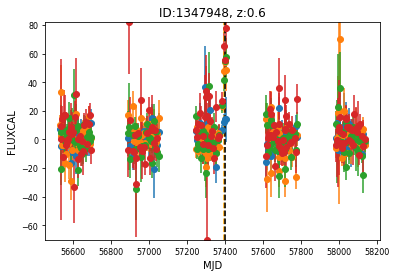

In [14]:
ax = plt.subplot()
vu.plot_single_lc(dummy,1347948,ax)

In [38]:
subseason = [0] + dummy.index[dummy['delta_time'] >100].tolist() + [len(dummy)]
subseason

[0, 112, 210, 313, 435, 539]

In [45]:
dic_dummy = {}
for i in range(len(subseason)-1):
    dic_dummy[i] = dummy[subseason[i]:subseason[i+1]]
# [k for k in dic_dummy[0].keys()]

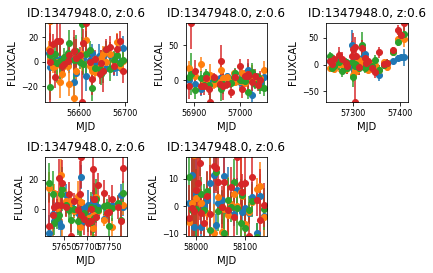

In [46]:
fig = plt.figure()
for i in range(len(dic_dummy)):
    ax = plt.subplot(2,3,i+1)
    vu.plot_single_lc(dic_dummy[i],dic_dummy[i]["SNID"].unique()[0],ax,plot_peak=False)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

LCs look good but, would supernnova be able to handle lcs that start maybe 100 days after the "subseason" starts?
Also, how should I identify these lcs? SNID is an int, maybe convert it to float?

# fit Bazin function to lc? 